In [1]:
# Some of the functions below require an older version of torchtext than the default one Kaggle gives you.
# Make sure that Internet is turned on.
!pip install torchtext==0.10.0
# exit()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.4/831.4 MB 2.0 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.14.1
    Uninstalling torchtext-0.14.1:
      Successfully uninstalled torchtext-0.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.1+cu116 requires torch==1.13.1, but you have torch 1.9.0 which is incompatible.
torchaudio 0.13.1+cu116 requires torch==1.13.1, but you have torch 1.9.0 which is incompatible.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# This block handles some basic setup and data loading.  
# You shouldn't need to edit this, but if you want to 
# import other standard python packages, that is fine.

# imports
from collections import defaultdict, Counter
import numpy as np
import math
import tqdm
import random
import pdb

import torch
from torch import nn
import torch.nn.functional as F
import torchtext

from torchtext.legacy import data
from torchtext.legacy import datasets

# download and load the data
text_field = data.Field()
datasets = datasets.WikiText2.splits(root='.', text_field=text_field)

train_dataset, validation_dataset, test_dataset = datasets

text_field.build_vocab(train_dataset, validation_dataset, test_dataset)
vocab = text_field.vocab
vocab_size = len(vocab)

train_text = train_dataset.examples[0].text # a list of tokens (strings)
validation_text = validation_dataset.examples[0].text

print(validation_text[:30])

downloading wikitext-2-v1.zip


wikitext-2-v1.zip: 100%|██████████| 4.48M/4.48M [00:01<00:00, 2.51MB/s]


extracting
['<eos>', '=', 'Homarus', 'gammarus', '=', '<eos>', '<eos>', 'Homarus', 'gammarus', ',', 'known', 'as', 'the', 'European', 'lobster', 'or', 'common', 'lobster', ',', 'is', 'a', 'species', 'of', '<unk>', 'lobster', 'from', 'the', 'eastern', 'Atlantic', 'Ocean']


In [4]:
text_field.vocab.freqs['.']

90077

In [5]:
from collections import defaultdict, Counter
import numpy as np
import math
import tqdm
import random
import pdb

import torch
from torch import nn
import torch.nn.functional as F
import torchtext

We've implemented a unigram model here as a demonstration.

In [6]:
class UnigramModel:
    def __init__(self, train_text):
        self.counts = Counter(train_text)
        self.total_count = len(train_text)

    def probability(self, word):
        return self.counts[word] / self.total_count

    def next_word_probabilities(self, text_prefix):
        """Return a list of probabilities for each word in the vocabulary."""
        return [self.probability(word) for word in vocab.itos]

    def perplexity(self, full_text):
        """Return the perplexity of the model on a text as a float.
        
        full_text -- a list of string tokens
        """
        log_probabilities = []
        for word in full_text:
            # Note that the base of the log doesn't matter 
            # as long as the log and exp use the same base.
            log_probabilities.append(math.log(self.probability(word), 2))
        return 2 ** -np.mean(log_probabilities)

unigram_demonstration_model = UnigramModel(train_text)
print('unigram validation perplexity:', 
      unigram_demonstration_model.perplexity(validation_text))

def check_validity(model, check_probs=True, check_perplexity=True):
    """Performs several sanity checks on your model:
    1) That next_word_probabilities returns a valid distribution
    2) That perplexity matches a perplexity calculated from next_word_probabilities

    Although it is possible to calculate perplexity from next_word_probabilities, 
    it is still good to have a separate more efficient method that only computes 
    the probabilities of observed words.
    """

    log_probabilities = []
    for i in range(10):
        # print(f"Trial {i}")
        prefix = validation_text[:i]
        probs = model.next_word_probabilities(prefix)
        if check_probs:
            assert min(probs) >= 0, "Negative value in next_word_probabilities"
            assert max(probs) <= 1 + 1e-8, "Value larger than 1 in next_word_probabilities"
            assert abs(np.sum(probs)-1) < 1e-4, f"next_word_probabilities do not sum to 1, sum is {np.sum(probs)}"
        word_id = vocab.stoi[validation_text[i]]
        selected_prob = probs[word_id]
        log_probabilities.append(math.log(selected_prob))

    if check_perplexity:
        perplexity = math.exp(-np.mean(log_probabilities))
        your_perplexity = model.perplexity(validation_text[:10])
        assert abs(perplexity-your_perplexity) < 0.1, "your perplexity does not " + \
        "match the one we calculated from `next_word_probabilities`,\n" + \
        "at least one of `perplexity` or `next_word_probabilities` is incorrect.\n" + \
        f"we calcuated {perplexity} from `next_word_probabilities`,\n" + \
        f"but your perplexity function returned {your_perplexity} (on a small sample)." + \
        f" Error % = {np.round((your_perplexity - perplexity) / perplexity * 100, 2)}%"


check_validity(unigram_demonstration_model)

unigram validation perplexity: 965.0860734119312


To generate from a language model, we can sample one word at a time conditioning on the words we have generated so far.

In [7]:
def generate_text(model, n=20, prefix=('<eos>', '<eos>')):
    prefix = list(prefix)
    for _ in range(n):
        probs = model.next_word_probabilities(prefix)
        word = random.choices(vocab.itos, probs)[0]
        prefix.append(word)
    return ' '.join(prefix)

print(generate_text(unigram_demonstration_model))

<eos> <eos> first it forced <unk> expanded population everything visible <unk> believed song over Sheen the The , Following shooting in the


In fact there are many strategies to get better-sounding samples, such as only sampling from the top-k words or sharpening the distribution with a temperature.  You can read more about sampling from a language model in this recent paper: https://arxiv.org/pdf/1904.09751.pdf.

You will need to submit some outputs from the models you implement for us to grade.  The following function will be used to generate the required output files.

In [8]:
!wget https://cal-cs288.github.io/sp21/project_files/proj_1/eval_prefixes.txt
!wget https://cal-cs288.github.io/sp21/project_files/proj_1/eval_output_vocab.txt
!wget https://cal-cs288.github.io/sp21/project_files/proj_1/eval_prefixes_short.txt
!wget https://cal-cs288.github.io/sp21/project_files/proj_1/eval_output_vocab_short.txt

def save_truncated_distribution(model, filename, short=True):
    """Generate a file of truncated distributions.
    
    Probability distributions over the full vocabulary are large,
    so we will truncate the distribution to a smaller vocabulary.

    Please do not edit this function
    """
    vocab_name = 'eval_output_vocab'
    prefixes_name = 'eval_prefixes'

    if short: 
      vocab_name += '_short'
      prefixes_name += '_short'

    with open('{}.txt'.format(vocab_name), 'r') as eval_vocab_file:
        eval_vocab = [w.strip() for w in eval_vocab_file]
    eval_vocab_ids = [vocab.stoi[s] for s in eval_vocab]

    all_selected_probabilities = []
    with open('{}.txt'.format(prefixes_name), 'r') as eval_prefixes_file:
        lines = eval_prefixes_file.readlines()
        # for line in tqdm.notebook.tqdm(lines, leave=False):
        # for line in lines:
        for line in tqdm.notebook.tqdm(lines, leave=False):
            prefix = line.strip().split(' ')
            probs = model.next_word_probabilities(prefix)
            selected_probs = np.array([probs[i] for i in eval_vocab_ids], dtype=np.float32)
            all_selected_probabilities.append(selected_probs)

    all_selected_probabilities = np.stack(all_selected_probabilities)
    np.save(filename, all_selected_probabilities)
    print('saved', filename)

--2023-02-08 21:58:04--  https://cal-cs288.github.io/sp21/project_files/proj_1/eval_prefixes.txt
Resolving cal-cs288.github.io (cal-cs288.github.io)... 185.199.111.153, 185.199.109.153, 185.199.108.153, ...
Connecting to cal-cs288.github.io (cal-cs288.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519055 (507K) [text/plain]
Saving to: ‘eval_prefixes.txt’

eval_prefixes.txt   100%[===================>] 506.89K  --.-KB/s    in 0.006s  

2023-02-08 21:58:04 (82.7 MB/s) - ‘eval_prefixes.txt’ saved [519055/519055]

--2023-02-08 21:58:04--  https://cal-cs288.github.io/sp21/project_files/proj_1/eval_output_vocab.txt
Resolving cal-cs288.github.io (cal-cs288.github.io)... 185.199.111.153, 185.199.109.153, 185.199.108.153, ...
Connecting to cal-cs288.github.io (cal-cs288.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12497 (12K) [text/plain]
Saving to: ‘eval_output_vocab.txt’

eval_output_

In [9]:
save_truncated_distribution(unigram_demonstration_model, 
                            'unigram_demonstration_predictions.npy')

  0%|          | 0/1000 [00:00<?, ?it/s]

saved unigram_demonstration_predictions.npy


### N-gram Model

Now it's time to implement an n-gram language model.

Because not every n-gram will have been observed in training, use add-alpha smoothing to make sure no output word has probability 0.

$$P(w_2|w_1)=\frac{C(w_1,w_2)+\alpha}{C(w_1)+N\alpha}$$

where $N$ is the vocab size and $C$ is the count for the given bigram.  An alpha value around `3e-3`  should work.  Later, we'll replace this smoothing with model backoff.

One edge case you will need to handle is at the beginning of the text where you don't have `n-1` prior words.  You can handle this however you like as long as you produce a valid probability distribution, but just using a uniform distribution over the vocabulary is reasonable for the purposes of this project.

A properly implemented bi-gram model should get a perplexity below 510 on the validation set.

**Note**: Do not change the signature of the `next_word_probabilities` and `perplexity` functions.  We will use these as a common interface for all of the different model types.  Make sure these two functions call `n_gram_probability`, because later we are going to override `n_gram_probability` in a subclass. 
Also, we suggest pre-computing and caching the counts $C$ when you initialize `NGramModel` for efficiency. 

In [10]:
class NGramModel:
    def __init__(self, train_text, n=2, alpha=3e-3):
        # get counts and perform any other setup
        self.n = n
        self.smoothing = alpha

        # YOUR CODE HERE
        self.N = len(train_text)

        # perform counts
        self.prefix_counts = {}
        self.counts = {}
        for i in range(n - 1, self.N):
            prefix = " ".join(train_text[i - n + 1: i])
            ngram = " ".join(train_text[i - n + 1 : i + 1])
            self.prefix_counts[prefix] = self.prefix_counts.get(prefix, 0) + 1
            self.counts[ngram] = self.counts.get(ngram, 0) + 1


    def n_gram_probability(self, n_gram):
        """Return the probability of the last word in an n-gram.
        
        n_gram -- a list of string tokens
        returns the conditional probability of the last token given the rest.
        """
        assert len(n_gram) == self.n, f"n_gram length is {len(n_gram)} and we are using a {self.n}-gram model"

        # YOUR CODE HERE
        prefix = " ".join(n_gram[:-1])
        n_gram = " ".join(n_gram)
        if self.n == 1:
            return self.counts.get(n_gram, 0) / self.N
        # denom = self.prefix_counts.get(prefix, 0) + self.N * self.smoothing
        denom = self.prefix_counts.get(prefix, 0) + len(vocab.itos) * self.smoothing
        numer = self.counts.get(n_gram, 0) + self.smoothing
        return numer / denom


    def next_word_probabilities(self, text_prefix):
        """Return a list of probabilities for each word in the vocabulary."""

        # YOUR CODE HERE
        # use your function n_gram_probability
        # vocab.itos contains a list of words to return probabilities for

        prob_dist = []
        if self.n == 1:
            return [self.counts.get(word, 0) / self.N for word in vocab.itos]
        for word in vocab.itos:
            # print(text_prefix + [word])
            n_gram = text_prefix + [word]
            n_gram = n_gram[-self.n:]
            if len(n_gram) < self.n:
                prob_dist.append(1 / len(vocab.itos))
            else:
                prob_dist.append(self.n_gram_probability(n_gram))
        return prob_dist


    def perplexity(self, full_text):
        """ full_text is a list of string tokens
        return perplexity as a float """

        # YOUR CODE HERE
        # use your function n_gram_probability
        # This method should differ a bit from the example unigram model because 
        # the first n-1 words of full_text must be handled as a special case.

        log_probabilities = []
        if self.n == 1:
            for i, word in enumerate(full_text):
                log_probabilities.append(math.log(self.n_gram_probability([word]), 2))
            return 2 ** -np.mean(log_probabilities)

        else:
            for i, word in enumerate(full_text):
                if i + 1 >= self.n:
                    log_probabilities.append(math.log(self.n_gram_probability(full_text[i - self.n + 1: i + 1]), 2))
                else:
                    log_probabilities.append(math.log(1 / len(vocab.itos), 2))
            return 2 ** -np.mean(log_probabilities)


unigram_model = NGramModel(train_text, 1)
check_validity(unigram_model)
print('unigram validation perplexity:', unigram_model.perplexity(validation_text)) # this should be the almost the same as our unigram model perplexity above

bigram_model = NGramModel(train_text, n=2)
check_validity(bigram_model)
print('bigram validation perplexity:', bigram_model.perplexity(validation_text))

trigram_model = NGramModel(train_text, n=3)
check_validity(trigram_model)
print('trigram validation perplexity:', trigram_model.perplexity(validation_text)) # this won't do very well...

save_truncated_distribution(bigram_model, 'bigram_predictions.npy') # this might take a few minutes

unigram validation perplexity: 965.0860734119312
bigram validation perplexity: 504.4293845601492
trigram validation perplexity: 2965.6641944027774


  0%|          | 0/1000 [00:00<?, ?it/s]

saved bigram_predictions.npy


Please download `bigram_predictions.npy` once you finish this section so that you can submit it.

In the block below, please report your bigram validation perplexity.  (We will use this to help us calibrate our scoring on the test set.)

<!-- Do not remove this comment, it is used by the autograder: RqYJKsoTS6 -->

Bigram validation perplexity: ***504.43***

We can also generate samples from the model to get an idea of how it is doing.

In [10]:
print(generate_text(bigram_model))

<eos> <eos> <eos> Written surrender embassy mints Assyrian Hyde Arnold knights keeping Solomon vertebrae orally attributes Akropolites funnels Tipu Terminator Historians Polish


We now free up some RAM, **it is important to run the cell below, otherwise you will likely run out of RAM in the Colab runtime.**

In [11]:
# Free up some RAM. 
del bigram_model
del trigram_model

This basic model works okay for bigrams, but a better strategy (especially for higher-order models) is to use backoff.  Implement backoff with absolute discounting.
$$P\left(w_i|w_{i-n+1}^{i-1}\right)=\frac{max\left\{C(w_{i-n+1}^i)-\delta,0\right\}}{\sum_{w_i} C(w_{i-n+1}^i)} + \alpha(w_{i-n+1}^{i-1}) P(w_i|w_{i-n+2}^{i-1})$$

$$\alpha\left(w_{i-n+1}^{i-1}\right)=\frac{\delta N_{1+}(w_{i-n+1}^{i-1})}{{\sum_{w_i} C(w_{i-n+1}^i)}}$$
where $N_{1+}$ is the number of words that appear after the previous $n-1$ words (the number of times the max will select something other than 0 in the first equation).  If $\sum_{w_i} C(w_{i-n+1}^i)=0$, use the lower order model probability directly (the above equations would have a division by 0).

We found a discount $\delta$ of 0.9 to work well based on validation performance.  A trigram model with this discount value should get a validation perplexity below 275.

In [12]:
class DiscountBackoffModel(NGramModel):
    def __init__(self, train_text, lower_order_model, n=2, delta=0.9):
        super().__init__(train_text, n=n)
        self.lower_order_model = lower_order_model
        self.discount = delta

        # YOUR CODE HERE
        self.N_1_plus = {}
        for i in range(self.n - 1, len(train_text)):
            prefix = " ".join(train_text[i - self.n + 1 : i])
            word = train_text[i]
            if prefix in self.N_1_plus:
                self.N_1_plus[prefix].add(word)
            else:
                self.N_1_plus[prefix] = set()
                self.N_1_plus[prefix].add(word)

        for key in self.N_1_plus.keys():
            self.N_1_plus[key] = len(self.N_1_plus[key])

    def n_gram_probability(self, n_gram):
        assert len(n_gram) == self.n, f"n_gram length is {len(n_gram)} and we are using a {self.n}-gram model"

        # YOUR CODE HERE
        # back off to the lower_order model with n'=n-1 using its n_gram_probability function
        pretext = n_gram[:-1]
        n_gram_key = " ".join(n_gram)
        numer = max(self.counts.get(n_gram_key, 0) - self.discount, 0)
        denom = self.prefix_counts.get(" ".join(pretext), 0)
        if denom == 0:
            return self.lower_order_model.n_gram_probability(n_gram[1:])
        else:
            prob = numer / denom
        
        alpha = self.discount * self.N_1_plus.get(" ".join(pretext), 0) / denom
        backoff_prob = self.lower_order_model.n_gram_probability(n_gram[1:])
        backoff = prob + alpha * backoff_prob
        if backoff == 0:
            return self.lower_order_model.n_gram_probability(n_gram[1:])
        return backoff 


bigram_backoff_model = DiscountBackoffModel(train_text, unigram_model, 2)
trigram_backoff_model = DiscountBackoffModel(train_text, bigram_backoff_model, 3)
check_validity(trigram_backoff_model, check_probs=False, check_perplexity=True)
print('trigram backoff validation perplexity:', trigram_backoff_model.perplexity(validation_text))

trigram backoff validation perplexity: 271.1253559258509


In [13]:
print(generate_text(trigram_backoff_model))

<eos> <eos> = = Background = = <eos> <eos> <eos> The convoy in the season , while Ross story <unk> added a


Free up RAM. 

In [14]:
# Release models we don't need any more. 
del unigram_model
del bigram_backoff_model
del trigram_backoff_model

Fill in your trigram backoff perplexity here.

<!-- Do not remove this comment, it is used by the autograder: RqYJKsoTS6 -->

Trigram backoff validation perplexity: ***271.13***



Free up RAM. 

### Neural N-gram Model

In this section, you will implement a neural version of an n-gram model.  The model will use a simple feedforward neural network that takes the previous `n-1` words and outputs a distribution over the next word.

You will use PyTorch to implement the model.  We've provided a little bit of code to help with the data loading using PyTorch's data loaders (https://pytorch.org/docs/stable/data.html)

A model with the following architecture and hyperparameters should reach a validation perplexity below 226.
* embed the words with dimension 128, then flatten into a single embedding for $n-1$ words (with size $(n-1)*128$)
* run 2 hidden layers with 1024 hidden units, then project down to size 128 before the final layer (ie. 4 layers total). 
* use weight tying for the embedding and final linear layer (this made a very large difference in our experiments); you can do this by creating the output layer with `nn.Linear`, then using `F.embedding` with the linear layer's `.weight` to embed the input
* rectified linear activation (ReLU) and dropout 0.1 after first 2 hidden layers. **Note: You will likely find a performance drop if you add a nonlinear activation function after the dimension reduction layer.**
* train for 10 epochs with the Adam optimizer (should take around 15-20 minutes)
* do early stopping based on validation set perplexity (see Project 0)


We encourage you to try other architectures and hyperparameters, and you will likely find some that work better than the ones listed above.  A proper implementation with these should be enough to receive full credit on the assignment, though.

In [16]:
from tqdm import trange
import copy

def ids(tokens):
    return [vocab.stoi[t] for t in tokens]

assert torch.cuda.is_available(), "no GPU found, in Colab go to 'Edit->Notebook settings' and choose a GPU hardware accelerator"

class NeuralNgramDataset(torch.utils.data.Dataset):
    def __init__(self, text_token_ids, n):
        self.text_token_ids = text_token_ids
        self.n = n

    def __len__(self):
        return len(self.text_token_ids)

    def __getitem__(self, i):
        if i < self.n-1:
            prev_token_ids = [vocab.stoi['<eos>']] * (self.n-i-1) + self.text_token_ids[:i]
        else:
            prev_token_ids = self.text_token_ids[i-self.n+1:i]

        assert len(prev_token_ids) == self.n-1

        x = torch.tensor(prev_token_ids)
        y = torch.tensor(self.text_token_ids[i])
        return x, y

class NeuralNGramNetwork(nn.Module):
    # a PyTorch Module that holds the neural network for your model

    def __init__(self, n):
        super().__init__()
        self.n = n

        # YOUR CODE HERE
        self.layer1 = nn.Linear((self.n - 1) * 128, 1024)
        self.layer2 = nn.Linear(1024, 1024)
        self.layer3 = nn.Linear(1024, 128)
        self.final_layer = nn.Linear(128, 33279, bias=False)

        self.do1 = nn.Dropout(0.1)
        self.do2 = nn.Dropout(0.1)

    def forward(self, x):
        # x is a tensor of inputs with shape (batch, n-1)
        # this function returns a tensor of log probabilities with shape (batch, vocab_size)

        # YOUR CODE HERE
        x = F.embedding(x, self.final_layer.weight)
        # print(x.shape)
        x = torch.flatten(x, 1)
        x = self.layer1(x)
        x = self.do1(F.relu(x))
        x = self.layer2(x)
        x = self.do2(F.relu(x))
        x = self.layer3(x)
        x = self.final_layer(x)
        return x

    def classify(self, x):
        if len(x.shape) == 1:
            x = torch.unsqueeze(x, dim=0)
        x = self(x)
        # x = torch.softmax(x, dim=1)
        x = torch.softmax(x, dim=1)
        # x = torch.log_softmax(x, dim=1)
        return torch.squeeze(x)

class NeuralNGramModel:
    # a class that wraps NeuralNGramNetwork to handle training and evaluation
    # it's ok if this doesn't work for unigram modeling
    def __init__(self, n):
        self.n = n
        self.network = NeuralNGramNetwork(n).cuda()
        # self.network = NeuralNGramNetwork(n)

    def train(self):
        dataset = NeuralNgramDataset(ids(train_text), self.n)
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)
        # iterating over train_loader with a for loop will return a 2-tuple of batched tensors
        # the first tensor will be previous token ids with size (batch, n-1),
        # and the second will be the current token id with size (batch, )
        # you will need to move these tensors to GPU, e.g. by using the Tensor.cuda() function.

        # this will take some time to run; use tqdm.tqdm_notebook to get a progress bar 
        # (see Project 1a for example)

        # YOUR CODE HERE
        optim = torch.optim.Adam(self.network.parameters())
        loss_fn = nn.CrossEntropyLoss()
        epochs = 10
        total = len(train_loader)
        best_perp, best_model = 10000000, None
        for epoch in range(epochs):
            # print(f"Epoch {epoch}")
            for i, data in tqdm.tqdm(enumerate(train_loader), desc=f"Epoch {epoch}", unit='batch', total=total):
                X, y = data
                X = X.cuda()
                y = y.cuda()
                out = self.network(X)
                loss = loss_fn(out, y)

                optim.zero_grad()
                loss.backward()
                optim.step()
            
            # early stopping
            perp = self.perplexity(validation_text)
            if perp < best_perp:
                best_perp = perp
                print(f"Best perplexity so far: {best_perp} - model saved")
                best_model = copy.deepcopy(self.network)

        torch.save(best_model.state_dict(), "/content/drive/MyDrive/cs288_s2023/hw1/Neural_NGram_Model.pt")


    def next_word_probabilities(self, text_prefix):
        # YOUR CODE HERE
        # don't forget self.network.eval()
        # you will need to convert text_prefix from strings to numbers with the `ids` function
        # if your `perplexity` function below is based on a NeuralNgramDataset DataLoader, you will need to use the same strategy for prefixes with less than n-1 tokens to pass the validity check
        #   the data loader appends extra "<eos>" (end of sentence) tokens to the start of the input so there are always enough to run the network

        self.network.eval()
        if len(text_prefix) < self.n - 1:
            text_prefix = ["<eos>"] * (self.n - 1 - len(text_prefix)) + text_prefix
        tokenized = torch.tensor(ids(text_prefix)).cuda()
        if len(tokenized) >= self.n:
            tokenized = tokenized[-self.n + 1 :]
        assert len(tokenized) == self.n - 1, f"text_prefix ({len(tokenized)}) and self.n {(self.n - 1)} do NOT match up"
        prob_dist = self.network.classify(tokenized).squeeze()
        self.network.train()
        return prob_dist.cpu().tolist()


    def perplexity(self, text):
        # you may want to use a DataLoader here with a NeuralNgramDataset
        # don't forget self.network.eval()

        # YOUR CODE HERE

        self.network.eval()
        log_probabilities = []
        dataloader = NeuralNgramDataset(ids(text), self.n)
        for X, y in dataloader:
            X = X.cuda()
            y = y.cuda()
            dist = self.network.classify(X)
            log_probabilities.append(math.log(dist[y], 2))
        self.network.train()
        return 2 ** -np.mean(log_probabilities)


neural_trigram_model = NeuralNGramModel(3)
# print(neural_trigram_model.network)
# neural_trigram_model.network.load_state_dict(torch.load("/content/drive/MyDrive/cs288_s2023/hw1/Neural_NGram_Model.pt"))
check_validity(neural_trigram_model, check_probs=True, check_perplexity=True)
neural_trigram_model.train()
print('neural trigram validation perplexity:', neural_trigram_model.perplexity(validation_text))

save_truncated_distribution(neural_trigram_model, 'neural_trigram_predictions.npy', short=False)

Epoch 0: 100%|██████████| 16318/16318 [01:23<00:00, 195.45batch/s]


Best perplexity so far: 234.70049762917523 - model saved


Epoch 1: 100%|██████████| 16318/16318 [01:23<00:00, 195.65batch/s]


Best perplexity so far: 212.3069950747369 - model saved


Epoch 2: 100%|██████████| 16318/16318 [01:23<00:00, 196.23batch/s]


Best perplexity so far: 207.61919652073442 - model saved


Epoch 4: 100%|██████████| 16318/16318 [01:22<00:00, 198.38batch/s]


Best perplexity so far: 207.58546918389172 - model saved


Epoch 9: 100%|██████████| 16318/16318 [01:23<00:00, 196.46batch/s]


neural trigram validation perplexity: 225.94829331075408


  0%|          | 0/5000 [00:00<?, ?it/s]

saved neural_trigram_predictions.npy


Fill in your neural trigram perplexity.

<!-- Do not remove this comment, it is used by the autograder: RqYJKsoTS6 -->

Neural trigram validation perplexity: ***225***

Free up RAM.

In [24]:
# Delete model we don't need. 
del neural_trigram_model

### LSTM Model

For this stage of the project, you will implement an LSTM language model.

For recurrent language modeling, the data batching strategy is a bit different from what is used in some other tasks.  Sentences are concatenated together so that one sentence starts right after the other, and an unfinished sentence will be continued in the next batch.  We'll use the `torchtext` library to manage this batching for you.  To properly deal with this input format, you should save the last state of the LSTM from a batch to feed in as the first state of the next batch.  When you save state across different batches, you should call `.detach()` on the state tensors before the next batch to tell PyTorch not to backpropagate gradients through the state into the batch you have already finished (which will cause a runtime error).

We expect your model to reach a validation perplexity below 130.  The following architecture and hyperparameters should be sufficient to get there.
* 3 LSTM layers with 512 units
* dropout of 0.5 after each LSTM layer
* instead of projecting directly from the last LSTM output to the vocabulary size for softmax, project down to a smaller size first (e.g. 512->128->vocab_size). **NOTE: You may find that adding nonlinearities between these layers can hurt performance, try without first.**
* use the same weights for the embedding layer and the pre-softmax layer; dimension 128
* train with Adam (using default learning rates) for at least 20 epochs


In [51]:
import copy

def ids(tokens):
    return [vocab.stoi[t] for t in tokens]

vocab_size = len(vocab.itos)

class LSTMNetwork(nn.Module):
    # a PyTorch Module that holds the neural network for your model

    def __init__(self):
        super().__init__()

        # YOUR CODE HERE
        self.lstm_layer = nn.LSTM(input_size=128, hidden_size=512, num_layers=3, dropout=0.5, batch_first=False)
        self.layer1 = nn.Linear(512, 128)
        self.layer2 = nn.Linear(128, vocab_size, bias=False)

        self.do = nn.Dropout(0.5)

    def forward(self, x, state, classify=False):
        """Compute the output of the network.
        
        Note: In the Pytorch LSTM tutorial, the state variable is named "hidden":
        https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

        The torch.nn.LSTM documentation is quite helpful:
        https://pytorch.org/docs/stable/nn.html#lstm
    
        x - a tensor of int64 inputs with shape (seq_len, batch)
        state - a tuple of two tensors with shape (num_layers, batch, hidden_size)
                representing the hidden state and cell state of the of the LSTM.
        returns a tuple with two elements:
          - a tensor of log probabilities with shape (seq_len, batch, vocab_size)
          - a state tuple returned by applying the LSTM.
        """

        # Note that the nn.LSTM module expects inputs with the sequence 
        # dimension before the batch by default.
        # In this case the dimensions are already in the right order, 
        # but watch out for this since sometimes people put the batch first

        # YOUR CODE HERE
        seq_len, batch = x.shape
        x = F.embedding(x, self.layer2.weight)  # returns [32, 64, 128]
        # x = torch.permute(x, (1, 0, 2))
        x, (h, c) = self.lstm_layer(x, state)
        x = self.do(x)
        x = self.layer1(x)
        x = self.layer2(x)
        if classify:
            x = F.softmax(x, dim=2)
            return x, (h, c)
        x = F.log_softmax(x, dim=2)
        assert x.shape == (seq_len, batch, len(vocab.itos)), f"Shape mismatch! x.shape = {x.shape}, but should be {(seq_len, batch, len(vocab.itos))}"
        return x, (h, c)

    def classify(self, x, state):
        return self(x, state, classify=True)


class LSTMModel:
    "A class that wraps LSTMNetwork to handle training and evaluation."

    def __init__(self):
        self.network = LSTMNetwork().cuda()

    def train(self):
        train_iterator = data.BPTTIterator(train_dataset, batch_size=64, 
                                                     bptt_len=32, device='cuda')
        # Iterate over train_iterator with a for loop to get batches
        # each batch object has a .text and .target attribute with
        # token id tensors for the input and output respectively.

        # The initial state passed into the LSTM should be set to zero.

        # YOUR CODE HERE
        self.network.train()
        optim = torch.optim.Adam(self.network.parameters())
        loss_fn = nn.NLLLoss()
        # loss_fn = nn.CrossEntropyLoss()
        epochs = 20
        total = len(train_iterator)
        best_perp, best_model = 10000000, None

        hidden_state, cell_state = torch.zeros((3, 64, 512)).cuda(), torch.zeros((3, 64, 512)).cuda()
        for epoch in range(epochs):
            # print(f"Epoch {epoch}")
            for i, Xy in tqdm.tqdm(enumerate(train_iterator), desc=f"Epoch {epoch}", unit='batch', total=total):
                X, y = Xy.text, Xy.target
                X = X.cuda()
                y = y.cuda()
                # if X.shape[0] != 64:
                #     continue
                out, (hidden_state, cell_state) = self.network(X, (hidden_state, cell_state))
                out = torch.permute(out, (1, 0, 2))

                # print(out.shape, y.T.shape)
                loss = loss_fn(torch.transpose(out, 1, 2), y.T)

                optim.zero_grad()
                loss.backward()
                optim.step()

                hidden_state = hidden_state.detach()
                cell_state = cell_state.detach()
            
            
            # early stopping
            perp = self.dataset_perplexity(validation_dataset)
            if perp < best_perp:
                best_perp = perp
                print(f"Best perplexity so far: {best_perp} - model saved")
                best_model = copy.deepcopy(self.network)

        self.network = best_model
        torch.save(best_model.state_dict(), "/content/drive/MyDrive/cs288_s2023/hw1/LSTM_Model.pt")

    def next_word_probabilities(self, text_prefix):
        "Return a list of probabilities for each word in the vocabulary."

        prefix_token_tensor = torch.tensor(ids(text_prefix), device='cuda').view(-1, 1)
        
        # YOUR CODE HERE
        self.network.eval()
        prob_dist, (h, c) = self.network.classify(prefix_token_tensor, (torch.zeros((3, 1, 512)).cuda(), torch.zeros((3, 1, 512)).cuda()))
        self.network.train()
        return prob_dist[-1].squeeze().tolist()

    def dataset_perplexity(self, torchtext_dataset):
        "Return perplexity as a float."
        # Your code should be very similar to next_word_probabilities, but
        # run in a loop over batches. Use torch.no_grad() for extra speed.

        iterator = data.BPTTIterator(torchtext_dataset, batch_size=64, bptt_len=32, device='cuda')

        # YOUR CODE HERE
        self.network.eval()
        log_probs = []
        total = 0
        seq_len = 32
        states = (torch.zeros((3, 64, 512)).cuda(), torch.zeros((3, 64, 512)).cuda())
        h, c = states
        with torch.no_grad():
            for Xy in iterator:
                X = Xy.text
                y = Xy.target
                prob_dist, (h, c) = self.network.classify(X, (h, c))
                prob_dist = torch.permute(prob_dist, (1, 0, 2))
                y = y.T
                y = torch.unsqueeze(y, axis=2)
                perp = torch.squeeze(torch.gather(prob_dist, dim=2, index=y))
                perp = torch.log(perp)
                log_probs.append(perp.flatten())
        log_probs = torch.cat(log_probs).cpu().numpy()
        self.network.train()
        return np.exp(-np.mean(log_probs))
lstm_model = LSTMModel()
lstm_model.train()

print('lstm validation perplexity:', lstm_model.dataset_perplexity(validation_dataset))
save_truncated_distribution(lstm_model, '/content/drive/MyDrive/cs288_s2023/hw1/lstm_predictions.npy', short=False)

Epoch 0: 100%|██████████| 1020/1020 [01:22<00:00, 12.33batch/s]


Best perplexity so far: 431.9924011230469 - model saved


Epoch 1: 100%|██████████| 1020/1020 [01:22<00:00, 12.31batch/s]


Best perplexity so far: 263.5238342285156 - model saved


Epoch 2: 100%|██████████| 1020/1020 [01:23<00:00, 12.27batch/s]


Best perplexity so far: 213.31704711914062 - model saved


Epoch 3: 100%|██████████| 1020/1020 [01:23<00:00, 12.27batch/s]


Best perplexity so far: 186.72039794921875 - model saved


Epoch 4: 100%|██████████| 1020/1020 [01:23<00:00, 12.28batch/s]


Best perplexity so far: 172.87326049804688 - model saved


Epoch 5: 100%|██████████| 1020/1020 [01:22<00:00, 12.30batch/s]


Best perplexity so far: 164.1548309326172 - model saved


Epoch 6: 100%|██████████| 1020/1020 [01:22<00:00, 12.30batch/s]


Best perplexity so far: 156.9240264892578 - model saved


Epoch 7: 100%|██████████| 1020/1020 [01:23<00:00, 12.27batch/s]


Best perplexity so far: 147.85154724121094 - model saved


Epoch 8: 100%|██████████| 1020/1020 [01:23<00:00, 12.27batch/s]


Best perplexity so far: 142.55838012695312 - model saved


Epoch 9: 100%|██████████| 1020/1020 [01:22<00:00, 12.29batch/s]


Best perplexity so far: 138.41432189941406 - model saved


Epoch 10: 100%|██████████| 1020/1020 [01:22<00:00, 12.30batch/s]


Best perplexity so far: 136.16026306152344 - model saved


Epoch 11: 100%|██████████| 1020/1020 [01:22<00:00, 12.31batch/s]


Best perplexity so far: 133.09095764160156 - model saved


Epoch 12: 100%|██████████| 1020/1020 [01:22<00:00, 12.30batch/s]


Best perplexity so far: 132.35491943359375 - model saved


Epoch 13: 100%|██████████| 1020/1020 [01:23<00:00, 12.27batch/s]


Best perplexity so far: 131.81332397460938 - model saved


Epoch 14: 100%|██████████| 1020/1020 [01:23<00:00, 12.27batch/s]


Best perplexity so far: 129.88099670410156 - model saved


Epoch 15: 100%|██████████| 1020/1020 [01:22<00:00, 12.30batch/s]


Best perplexity so far: 127.7673110961914 - model saved


Epoch 16: 100%|██████████| 1020/1020 [01:22<00:00, 12.30batch/s]


Best perplexity so far: 127.71588897705078 - model saved


Epoch 17: 100%|██████████| 1020/1020 [01:22<00:00, 12.30batch/s]


Best perplexity so far: 127.0321273803711 - model saved


Epoch 18: 100%|██████████| 1020/1020 [01:23<00:00, 12.27batch/s]


Best perplexity so far: 126.77173614501953 - model saved


Epoch 19: 100%|██████████| 1020/1020 [01:23<00:00, 12.27batch/s]


Best perplexity so far: 126.28460693359375 - model saved


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:679: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:924.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


lstm validation perplexity: 126.28461


<ipython-input-7-ff9bb640c996>:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm.tqdm_notebook(lines, leave=False):


  0%|          | 0/5000 [00:00<?, ?it/s]

saved /content/drive/MyDrive/cs288_s2023/hw1/lstm_predictions.npy


<!-- Do not remove this comment, it is used by the autograder: RqYJKsoTS6 -->

Fill in your LSTM perplexity. 

LSTM validation perplexity: ***126.28***

# Experimentation: 1-Page Report

Now it's time for you to experiment.  Try to reach a validation perplexity below 120. You may either modify the LSTM class above, or copy it down to the code cell below and modify it there. Just **be sure to run code cell below to generate results with your improved LSTM**.  

It is okay if the bulk of your improvements are due to hyperparameter tuning (such as changing number or sizes of layers), but implement at least one more substantial change to the model.  Here are some ideas (several of which come from https://arxiv.org/pdf/1708.02182.pdf):
* activation regularization - add a l2 regularization penalty on the activation of the LSTM output (standard l2 regularization is on the weights)
* weight-drop regularization - apply dropout to the weight matrices instead of activations
* learning rate scheduling - decrease the learning rate during training
* embedding dropout - zero out the entire embedding for a random set of words in the embedding matrix
* ensembling - average the predictions of several models trained with different initialization random seeds
* temporal activation regularization - add l2 regularization on the difference between the LSTM output activations at adjacent timesteps

You may notice that most of these suggestions are regularization techniques.  This dataset is considered fairly small, so regularization is one of the best ways to improve performance.

For this section, you will submit a write-up describing the extensions and/or modifications that you tried.  Your write-up should be **1-page maximum** in length and should be submitted in PDF format.  You may use any editor you like, but we recommend using LaTeX and working in an environment like Overleaf.
For full credit, your write-up should include:
1.   A concise and precise description of the extension that you tried.
2.   A motivation for why you believed this approach might improve your model.
3.   A discussion of whether the extension was effective and/or an analysis of the results.  This will generally involve some combination of tables, learning curves, etc.
4.   A bottom-line summary of your results comparing validation perplexities of your improvement to the original LSTM.
The purpose of this exercise is to experiment, so feel free to try/ablate multiple of the suggestions above as well as any others you come up with!
When you submit the file, please name it `report.pdf`.



Run the cell below in order to train your improved LSTM and evaluate it.  

In [68]:
for name, x in lstm_model.network.named_parameters():
    print(name)
    print(torch.norm(x))

lstm_layer.weight_ih_l0
tensor(178.0163, device='cuda:0', grad_fn=<CopyBackwards>)
lstm_layer.weight_hh_l0
tensor(125.5634, device='cuda:0', grad_fn=<CopyBackwards>)
lstm_layer.bias_ih_l0
tensor(7.3833, device='cuda:0', grad_fn=<CopyBackwards>)
lstm_layer.bias_hh_l0
tensor(7.3286, device='cuda:0', grad_fn=<CopyBackwards>)
lstm_layer.weight_ih_l1
tensor(199.7221, device='cuda:0', grad_fn=<CopyBackwards>)
lstm_layer.weight_hh_l1
tensor(129.3727, device='cuda:0', grad_fn=<CopyBackwards>)
lstm_layer.bias_ih_l1
tensor(9.0406, device='cuda:0', grad_fn=<CopyBackwards>)
lstm_layer.bias_hh_l1
tensor(9.0155, device='cuda:0', grad_fn=<CopyBackwards>)
lstm_layer.weight_ih_l2
tensor(203.0061, device='cuda:0', grad_fn=<CopyBackwards>)
lstm_layer.weight_hh_l2
tensor(178.2840, device='cuda:0', grad_fn=<CopyBackwards>)
lstm_layer.bias_ih_l2
tensor(7.9813, device='cuda:0', grad_fn=<CopyBackwards>)
lstm_layer.bias_hh_l2
tensor(7.9678, device='cuda:0', grad_fn=<CopyBackwards>)
layer1.weight
tensor(35.6157

In [86]:
## Feel free to copy your original LSTM solution down here to modify for your report if you'd like. 

class LSTMExtNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        # YOUR CODE HERE
        self.hidden_size = 720
        self.lstm_layer = nn.LSTM(input_size=128, hidden_size=self.hidden_size, num_layers=3, dropout=0.5, batch_first=False)
        self.layer1 = nn.Linear(self.hidden_size, 128)
        self.layer2 = nn.Linear(128, vocab_size, bias=False)

        self.do = nn.Dropout(0.5)


    def forward(self, x, state, classify=False):
        """Compute the output of the network.
        
        Note: In the Pytorch LSTM tutorial, the state variable is named "hidden":
        https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

        The torch.nn.LSTM documentation is quite helpful:
        https://pytorch.org/docs/stable/nn.html#lstm
    
        x - a tensor of int64 inputs with shape (seq_len, batch)
        state - a tuple of two tensors with shape (num_layers, batch, hidden_size)
                representing the hidden state and cell state of the of the LSTM.
        returns a tuple with two elements:
          - a tensor of log probabilities with shape (seq_len, batch, vocab_size)
          - a state tuple returned by applying the LSTM.
        """

        # Note that the nn.LSTM module expects inputs with the sequence 
        # dimension before the batch by default.
        # In this case the dimensions are already in the right order, 
        # but watch out for this since sometimes people put the batch first

        # YOUR CODE HERE
        seq_len, batch = x.shape
        x = F.embedding(x, self.layer2.weight)  # returns [32, 64, 128]
        # x = torch.permute(x, (1, 0, 2))
        x, (h, c) = self.lstm_layer(x, state)
        x = self.do(x)
        x = self.layer1(x)
        x = self.layer2(x)
        if classify:
            x = F.softmax(x, dim=2)
            return x, (h, c)
        x = F.log_softmax(x, dim=2)
        assert x.shape == (seq_len, batch, len(vocab.itos)), f"Shape mismatch! x.shape = {x.shape}, but should be {(seq_len, batch, len(vocab.itos))}"
        return x, (h, c)

    def classify(self, x, state):
        return self(x, state, classify=True)

class LSTMExtModel(LSTMModel):
    "A class that wraps LSTMNetwork to handle training and evaluation."

    def __init__(self):
        self.network = LSTMExtNetwork().cuda()

    def train(self):
        train_iterator = data.BPTTIterator(train_dataset, batch_size=64, 
                                                     bptt_len=32, device='cuda')
        # Iterate over train_iterator with a for loop to get batches
        # each batch object has a .text and .target attribute with
        # token id tensors for the input and output respectively.

        # The initial state passed into the LSTM should be set to zero.

        # YOUR CODE HERE
        self.network.train()
        optim = torch.optim.Adam(self.network.parameters(), weight_decay=0)
        # scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.1)
        loss_fn = nn.NLLLoss()
        epochs = 20
        total = len(train_iterator)
        best_perp, best_model = 10000000, None

        losses = []
        perps = []

        hidden_state, cell_state = torch.zeros((3, 64, self.network.hidden_size)).cuda(), torch.zeros((3, 64, self.network.hidden_size)).cuda()
        for epoch in range(epochs):

            for i, Xy in tqdm.tqdm(enumerate(train_iterator), desc=f"Epoch {epoch}", unit='batch', total=total):
                X, y = Xy.text, Xy.target
                X = X.cuda()
                y = y.cuda()

                out, (hidden_state, cell_state) = self.network(X, (hidden_state, cell_state))
                out = torch.permute(out, (1, 0, 2))

                # print(out.shape, y.T.shape)
                l2 = 0
                count = 0
                for name, layer in self.network.named_parameters():
                    if "lstm_layer.weight" in name:
                        l2 += torch.sum(layer ** 2)
                        count += 1
                # print(torch.sqrt(l2) / count)
                loss = loss_fn(torch.transpose(out, 1, 2), y.T) + torch.sqrt(l2) * 1e-4
                optim.zero_grad()
                loss.backward()
                optim.step()
                # scheduler.step()

                hidden_state = hidden_state.detach()
                cell_state = cell_state.detach()
            
            # early stopping
            perp = self.dataset_perplexity(validation_dataset)
            if perp < best_perp:
                best_perp = perp
                print(f"Best perplexity so far: {best_perp} - model saved")
                best_model = copy.deepcopy(self.network)
            
            losses.append(loss)
            perps.append(perp)

        self.network = best_model
        torch.save(best_model.state_dict(), "/content/drive/MyDrive/cs288_s2023/hw1/LSTM_Ext_Model.pt")
        return losses, perps
    def next_word_probabilities(self, text_prefix):
        "Return a list of probabilities for each word in the vocabulary."

        prefix_token_tensor = torch.tensor(ids(text_prefix), device='cuda').view(-1, 1)
        
        # YOUR CODE HERE
        self.network.eval()
        prob_dist, (h, c) = self.network.classify(prefix_token_tensor, (torch.zeros((3, 1, self.network.hidden_size)).cuda(), torch.zeros((3, 1, self.network.hidden_size)).cuda()))
        self.network.train()
        return prob_dist[-1].squeeze().tolist()

    def dataset_perplexity(self, torchtext_dataset):
        "Return perplexity as a float."
        # Your code should be very similar to next_word_probabilities, but
        # run in a loop over batches. Use torch.no_grad() for extra speed.

        iterator = data.BPTTIterator(torchtext_dataset, batch_size=64, bptt_len=32, device='cuda')

        # YOUR CODE HERE
        self.network.eval()
        log_probs = []
        total = 0
        seq_len = 32
        states = (torch.zeros((3, 64, self.network.hidden_size)).cuda(), torch.zeros((3, 64, self.network.hidden_size)).cuda())
        h, c = states
        with torch.no_grad():
            for Xy in iterator:
                X = Xy.text
                y = Xy.target
                prob_dist, (h, c) = self.network.classify(X, (h, c))
                prob_dist = torch.permute(prob_dist, (1, 0, 2))
                y = y.T
                y = torch.unsqueeze(y, axis=2)
                perp = torch.squeeze(torch.gather(prob_dist, dim=2, index=y))
                perp = torch.log(perp)
                log_probs.append(perp.flatten())
        log_probs = torch.cat(log_probs).cpu().numpy()
        self.network.train()
        return np.exp(-np.mean(log_probs))


lstm_ext_model = LSTMExtModel()
losses, perplexities = lstm_ext_model.train()
print('lstm validation perplexity:', lstm_ext_model.dataset_perplexity(validation_dataset))
save_truncated_distribution(lstm_model, '/content/drive/MyDrive/cs288_s2023/hw1/lstm_ext_predictions.npy', short=False)

Epoch 0: 100%|██████████| 1020/1020 [01:48<00:00,  9.39batch/s]


Best perplexity so far: 357.9732971191406 - model saved


Epoch 1: 100%|██████████| 1020/1020 [01:48<00:00,  9.36batch/s]


Best perplexity so far: 235.74887084960938 - model saved


Epoch 2: 100%|██████████| 1020/1020 [01:48<00:00,  9.39batch/s]


Best perplexity so far: 184.6054229736328 - model saved


Epoch 5: 100%|██████████| 1020/1020 [01:48<00:00,  9.40batch/s]


Best perplexity so far: 139.93356323242188 - model saved


Epoch 6: 100%|██████████| 1020/1020 [01:48<00:00,  9.37batch/s]


Best perplexity so far: 133.7799072265625 - model saved


Epoch 7: 100%|██████████| 1020/1020 [01:48<00:00,  9.39batch/s]


Best perplexity so far: 129.0544891357422 - model saved


Epoch 8: 100%|██████████| 1020/1020 [01:48<00:00,  9.40batch/s]


Best perplexity so far: 125.58963775634766 - model saved


Epoch 9: 100%|██████████| 1020/1020 [01:48<00:00,  9.37batch/s]


Best perplexity so far: 122.9131088256836 - model saved


Epoch 10: 100%|██████████| 1020/1020 [01:48<00:00,  9.40batch/s]


Best perplexity so far: 121.53761291503906 - model saved


Epoch 11: 100%|██████████| 1020/1020 [01:48<00:00,  9.38batch/s]


Best perplexity so far: 119.84613037109375 - model saved


Epoch 12: 100%|██████████| 1020/1020 [01:48<00:00,  9.39batch/s]


Best perplexity so far: 119.40495300292969 - model saved


Epoch 13: 100%|██████████| 1020/1020 [01:48<00:00,  9.38batch/s]


Best perplexity so far: 119.08382415771484 - model saved


Epoch 14: 100%|██████████| 1020/1020 [01:48<00:00,  9.36batch/s]


Best perplexity so far: 118.25489044189453 - model saved


Epoch 16: 100%|██████████| 1020/1020 [01:48<00:00,  9.39batch/s]


Best perplexity so far: 117.62462615966797 - model saved


Epoch 17: 100%|██████████| 1020/1020 [01:49<00:00,  9.35batch/s]


Best perplexity so far: 116.27605438232422 - model saved


Epoch 19: 100%|██████████| 1020/1020 [01:48<00:00,  9.36batch/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:679: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:924.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


lstm validation perplexity: 116.276054


<ipython-input-7-ff9bb640c996>:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm.tqdm_notebook(lines, leave=False):


  0%|          | 0/5000 [00:00<?, ?it/s]

saved /content/drive/MyDrive/cs288_s2023/hw1/lstm_ext_predictions.npy


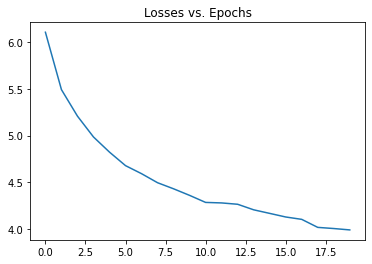

In [96]:
import matplotlib.pyplot as plt

epochs = [i for i in range(20)]
def graph(x, y, title):
    plt.plot(x, y)
    plt.title(title)

# losses = [loss.detach().cpu() for loss in losses]
# perplexities = [perp.detach().cpu() for perp in perplexities]

graph(epochs, losses, "Losses vs. Epochs")

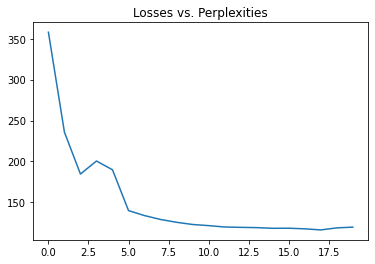

In [97]:
graph(epochs, perplexities, "Losses vs. Perplexities")

### Submission

Upload a submission with the following files to Gradescope:
* hw1b.ipynb (rename to match this exactly)
* lstm_predictions.npy (this should also include all improvements from your exploration)
* neural_trigram_predictions.npy
* bigram_predictions.npy
* report.pdf

You can upload files individually or as part of a zip file, but if using a zip file be sure you are zipping the files directly and not a folder that contains them.

Be sure to check the output of the autograder after it runs.  It should confirm that no files are missing and that the output files have the correct format.  Note that the test set perplexities shown by the autograder are on a completely different scale from your validation set perplexities due to truncating the distribution and selecting different text.  Don't worry if the values seem much worse.